Group Info
Nicolas Zhou 41741539
Scott Halston 

In [19]:
#setup - Continuing from stage 1
import os       #for os.listdir to get all files in a directory
import cv2      #img analysis for machine learning - PIL has processing limitations
import numpy as np
from numpy import ndarray
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=4096)

#import sklearn's linear model predictors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


#assuming during grading we only path_testing will be changed:

path_train  ="./Lego_dataset_2/Lego_dataset_2/training"
#assuming training data path leads directly to folder labelled "training"

path_test   ="./Lego_dataset_2/Lego_dataset_2/testing"
#assuming testing data path leads directly to folder labelled "testing"
IMG_LENGTH  = 128
IMG_SIZE    =(IMG_LENGTH , IMG_LENGTH) #normalize each image to 64 x64
LABELS      ={"2x1":0,"cir":1,"rec":2,"squ":3} #we will call this dictionary when assigning training labels to our images


In [20]:
#preprocessing feature extraction - we will code functions to get certain features of an image here, and call them below when needed

#assumptions:
#(stage1) image names will always start with "2x1", "squ", "cir", "rec" as shown above in #Setup
#(stage1) change these to y_p value of 0,1,2,3 for the sake of clarity

#(stage2) we will take features of the image rather than just the pixel data. sk learn, cv2 and has a number of feature extraction methods we will use.

#(stage2) feature. Image Perimeter
#(stage2) feature. Image Max Frequency using histogram
#(stage2) feature. Image Edge Features cv.canny

#when called, these functions get inputted image data in the form of an ndarray and return it in the form of an ndarray

#resize image - normalize all images to 64p x 64p
def resize_image(image_in):
    return cv2.resize(image_in, IMG_SIZE)


#grab features - edge features
def extract_edge_features(image_in):

    #cv2 has a very nice function in its library called .Canny. This extracts the image edge data using a gradient edge function. I have linked the documentation I have referenced below.
    #source - https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html
    #basically we give it some minval and some maxval and it returns us only pixels that when subtracted by its neighbours are in a certain range
    #we will grab the number of pixels that have edges; this will help with our edge evaluation and may differ from perimeter calculations

    #initialize calculable variables; sometimes image returns no contour. If this is the case, return 0 as a failsafe.
    area        = 0 #area of largest contour
    perimeter   = 0 #longest closed loop of largest contour
    ratio_l     = 0 #ratio of longest dimension to shortest dimension
    ratio_s     = 0 #ratio of shortest dimension to longest dimension
    longest     = 0 #longest dimension
    shortest    = 0 #shortest dimension
    compactness = 0 #roundness of largest contour
    vertices    = 0 #corners of object using epsilon calculation method
    corners     = 0 #corners of object using Harris Corner Detection algorithm
    edge_count  = 0 #counting the number of edges


    #we can grab a couple features using the edge function, cv2.canny
    #this uses a gradient edge function to find pixels with high differences with its neighbours

    #preprocess by turning the image into binary bnw and reducing noise using Gaussian Blur

    blurred = cv2.GaussianBlur(image_in, (7, 7), 0) #these numbers come from tinkering around for ~60 iterations


    #detect edges using .Canny
    edges = cv2.Canny(blurred, 49, 160) #these numbers come from tinkering around for ~60 iterations
    edge_count=np.count_nonzero(edges)

    #find contours using edges detected earlier; this will help draw bounding boxes
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #only check if contours exist, throw if else
    if contours:
        contour = max(contours, key=cv2.contourArea)  # Use the largest contour

        #calculate area and perimeter
        area = cv2.contourArea(contour)

        perimeter = cv2.arcLength(contour, closed=True)

        #calculate compactness using perimeter and area
        if perimeter > 0:
            compactness = 4*np.pi*area/perimeter**2

        #calculate the rotated bounding rectangle
        rotated_rect = cv2.minAreaRect(contour)
        width, height = rotated_rect[1]  # Width and height of the rectangle

        #calculate the longest-to-shortest length ratio
        if width > 0 and height > 0:  # Avoid division by zero
            longest = max(width, height)
            shortest = min(width, height)
            ratio_l = longest / shortest #take longest ratio
            ratio_s = shortest / longest #take shortest ratio

        #calculate the vertices
        epsilon = 0.02 * cv2.arcLength(contour, closed=True)
        approx = cv2.approxPolyDP(contour, epsilon, closed=True)
        vertices = len(approx)

        #calculate the corners using Harris Corner Detection
        edges_float = np.float32(edges)  # Convert to float for Harris Corner Detection
        corners_dilated = cv2.dilate(cv2.cornerHarris(edges_float, blockSize=2, ksize=3, k=0.04), None)
        threshold = 0.01 * corners_dilated.max()
        corners_binary = corners_dilated > threshold 
        corners = np.sum(corners_binary)

        #source - https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html
        #its a pretty cool feature where edges are found with sharpness matrices


    debug_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(debug_image, contours, -1, (0, 0, 255), 1)
    return debug_image, [area, perimeter, ratio_l,ratio_s, longest, shortest, compactness,vertices,edge_count,corners]

    #i have it set to return a outlined image representing the largest contour for visualization during our training/testing process. This has been disabled for our submission, though the code is still in comments in next section.

#all numbers used in the calculations can be changed slightly to see their effects on our data.


In [21]:
#Load Images to train

def load_images(path):
    image_data, image_label = [], []

    
    #use above function to grab each image's histogram

    #for each file in training path, non-indexed
    for file in os.listdir(path): 

        #full file path
        image_path = os.path.join(path,file)  

        #read image as grayscale
        #resize image
        image = resize_image(cv2.imread(image_path))

        #grab image features and a debug image
        debug_image,features = extract_edge_features(image)

        #debug images will automatically save to a folder labelled ".\Lego_dataset_2\Lego_dataset_2\debug\testing" and ".\Lego_dataset_2\Lego_dataset_2\debug\training" if present.
        #cv2.imwrite(f"./Lego_dataset_2/Lego_dataset_2/debug/{str(path)[32:]}/{file}",debug_image)
        #this has been turned off for our submission, but feel free to test it out. They show all images with outlined contours and may bring insite to how we obtained our calculations/features.

        #put all of them per label
        image_data.append(features)

        image_label.append(LABELS[file[:3]])

    return image_data, image_label

#this function's purpose is to obtain all images in a given file directory (path variable in setup)

In [22]:
#Training Classifier - TRAINING

#setup a linear training model using sklearn's svc to help classify images as it uses multiple 1 vs 1 classifications
def train_model(path):
    x_train, y_train = load_images(path)

    model = LogisticRegression(fit_intercept=False, max_iter=4097)
    #this is the same as lecture 5; x data in a 108x10 matrix

    model.fit(x_train, y_train)

    return model



In [23]:
#Classify function - TESTING

#using c_ to signify new variables
def classify_images(path)->tuple:
        
    #obtain image/function data of path using load_images
    c_x_test, c_y_test = load_images(path)

    #train model using above function + training folder path
    c_model = train_model(path_train) 
    
    #predict the y values of each new x_test value
    c_y_pred = c_model.predict(c_x_test)
    
    #return the confusion matrix as well as accuracy score of the test sample vs the training sample as a tuple

    #training/testing to show which images are not passing the test
    #for i in range(len(c_y_pred)):
    #    if c_y_pred[i] != c_y_test[i]:
    #        print(os.listdir(path)[i])


    return confusion_matrix(c_y_test,c_y_pred),accuracy_score(c_y_test,c_y_pred)
    

Accuracy Score: 100.0%
Accuracy Score: 94.444444%


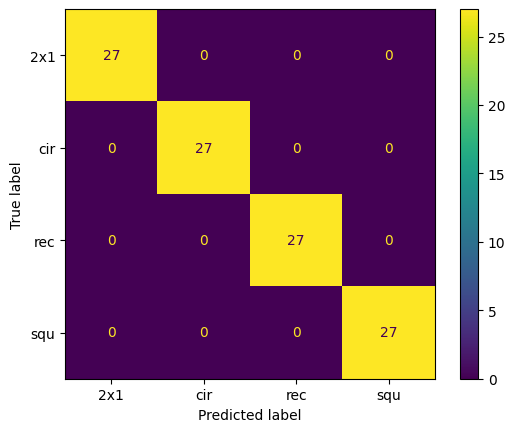

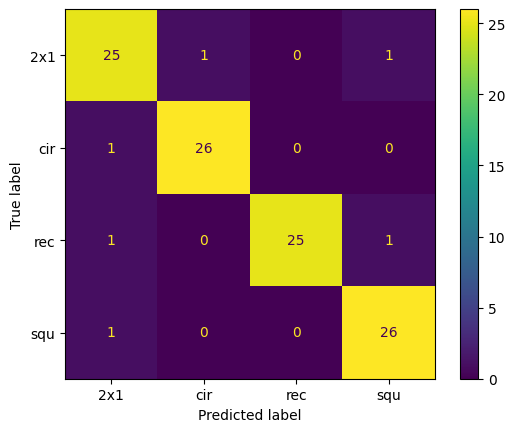

In [24]:
#Run Function
def test_function(path):
    #calls classify function to given path, returns confusion matrix and accuracy score
    c_matrix, accuracy = classify_images(path)


    disp = ConfusionMatrixDisplay(c_matrix,display_labels=LABELS.keys())
    disp.plot()
    

    print(f"Accuracy Score: {round(accuracy*100,6)}%")#\nFor data set located at {path}")

test_function(path_train)

test_function(path_test)

